In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

In [2]:
datos_pacientes = pd.read_csv("./data/Datos_Limpios_Lab1.csv")

In [3]:
data = datos_pacientes.copy()

In [4]:
data["Date of Service"] = pd.to_datetime(data["Date of Service"], errors="coerce", dayfirst=True)

data["Date of Service"] = data["Date of Service"].dt.strftime("%Y-%m-%d")

# Ordenar por Id y Fecha
data = data.sort_values(["Patient ID", "Date of Service"])

# Para cada Id nos quedamos con el registro más reciente
data = data.drop_duplicates(subset="Patient ID", keep="last")

C:\Users\scast\AppData\Local\Temp\ipykernel_7940\3045502807.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date of Service"] = pd.to_datetime(data["Date of Service"], errors="coerce", dayfirst=True)


In [5]:
target = "CVD Risk Score"
X = data.drop(columns=[target])
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)

In [7]:
X_train.shape, y_train.shape

((1078, 41), (1078,))

In [8]:
X_test.shape, y_test.shape

((270, 41), (270,))

In [11]:
cols_to_drop = ["Id", "Fecha", "CodigoPostal"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

### 1. Modelo de Regresión Polinomial

## Objetivo
Construir un pipeline que incluya generación de características polinomiales y regresión lineal, explorando diferentes grados de polinomios y estrategias de escalamiento para identificar el punto de sobreajuste.

In [12]:
# Configurar el estilo de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
cols_to_drop = ['Patient ID', 'Date of Service',]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

In [14]:
numeric_features = [
    'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 
    'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 
    'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 
    'Estimated LDL (mg/dL)', 'BMI_Age', 'BMI_Systolic', 'Age_Cholesterol', 
    'Systolic_Diastolic', 'Total Cholesterol (mg/dL)_log', 
    'Fasting Blood Sugar (mg/dL)_log', 'BMI_log', 'Age_squared', 'BMI_squared', 
    'Systolic BP_squared', 'Cholesterol_HDL_Ratio', 'Mean_Arterial_Pressure', 
    'Pulse_Pressure', 'Atherogenic_Index', 'Glucose_HDL_Ratio', 'BMI_Age_Adjusted', 
    'Pulse_Pressure_Age_Adjusted', 'Ponderal_Index', 'BP_Load', 'WHR_Squared', 
    'Lipid_Risk_Index'
]

categorical_features = [ 
    'Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 
    'Family History of CVD'
]

print(f"Características numéricas: {numeric_features}")
print(f"Características categóricas: {categorical_features}")  
print(f"Total: {len(numeric_features) + len(categorical_features)} características")

Características numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'BMI_Age', 'BMI_Systolic', 'Age_Cholesterol', 'Systolic_Diastolic', 'Total Cholesterol (mg/dL)_log', 'Fasting Blood Sugar (mg/dL)_log', 'BMI_log', 'Age_squared', 'BMI_squared', 'Systolic BP_squared', 'Cholesterol_HDL_Ratio', 'Mean_Arterial_Pressure', 'Pulse_Pressure', 'Atherogenic_Index', 'Glucose_HDL_Ratio', 'BMI_Age_Adjusted', 'Pulse_Pressure_Age_Adjusted', 'Ponderal_Index', 'BP_Load', 'WHR_Squared', 'Lipid_Risk_Index']
Características categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD']
Total: 39 características


In [15]:
numeric_transforme_polinomial = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=2)),
    ]
)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

In [16]:
preprocessor_polinomial = ColumnTransformer(
    transformers=[
        ("num", numeric_transforme_polinomial, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [17]:
pipeline_regresion_polinomial = Pipeline(steps=[
    ("dropper", dropper),
    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", LinearRegression()),
])

In [18]:
# Definir parámetros para GridSearchCV
param_grid = {
    'preprocesamiento__num__scaler': [StandardScaler(), None],
    'preprocesamiento__num__polynomial__degree': [2, 3, 4, 5],  # Grado del polinomio
}

In [19]:
# Crear GridSearchCV con validación cruzada (5 folds)
grid = GridSearchCV(
    pipeline_regresion_polinomial,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1
)

print("Iniciando búsqueda exhaustiva de hiperparámetros...")
print(f"Combinaciones a evaluar: {len(param_grid['preprocesamiento__num__scaler']) * len(param_grid['preprocesamiento__num__polynomial__degree'])} × 5 folds")


Iniciando búsqueda exhaustiva de hiperparámetros...
Combinaciones a evaluar: 8 × 5 folds


In [20]:
# 1.2 Ejecutar GridSearchCV
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\scast\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(X

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        FunctionTransformer(func=<function drop_columns at 0x000001FD66421120>)),
                                       ('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures())]),
                                                                         ['Age',
                                                                          'Weight '
                                                                          '(kg)',
                                                                          'Height '
                                                                          '(m)',
                                                                          'BMI',
                                                                          'Abdominal '
                                                                          'Ci...
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Smoking '
                                                                          'Status',
                                                                          'Diabetes '
                                                                          'Status',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Family '
                                                                          'History '
                                                                          'of '
                                                                          'CVD'])])),
                                       ('modelo', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocesamiento__num__polynomial__degree': [2, 3, 4,
                                                                       5],
                         'preprocesamiento__num__scaler': [StandardScaler(),
                                                           None]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
print(f"\nBúsqueda completada en {grid.n_splits_} folds")
print(f"\nMejores hiperparámetros encontrados:")
print(f"  - Escalador: {grid.best_params_['preprocesamiento__num__scaler'].__class__.__name__ if grid.best_params_['preprocesamiento__num__scaler'] is not None else 'Ninguno (Sin escalamiento)'}")
print(f"  - Grado del polinomio: {grid.best_params_['preprocesamiento__num__polynomial__degree']}")
print(f"\nMejor RMSE en validación cruzada: {sqrt(-grid.best_score_):.4f}")
print(f"Mejor MSE en validación cruzada: {-grid.best_score_:.4f}")


Búsqueda completada en 5 folds

Mejores hiperparámetros encontrados:
  - Escalador: StandardScaler
  - Grado del polinomio: 3

Mejor RMSE en validación cruzada: 4280.1347
Mejor MSE en validación cruzada: 18319553.2503


In [24]:
# 1.3 Evaluar el mejor modelo en train y test

best_model = grid.best_estimator_

# Predicciones
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, set_name=""):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MSE': mse
    }

metrics_train = calculate_metrics(y_train, y_train_pred, "Train")
metrics_test = calculate_metrics(y_test, y_test_pred, "Test")

# Crear tabla comparativa
results_df = pd.DataFrame({
    'Train': metrics_train,
    'Test': metrics_test,
    'Diferencia (Train - Test)': {k: metrics_train[k] - metrics_test[k] for k in metrics_train.keys()}
})

print("\n" + "="*70)
print("MÉTRICAS DEL MEJOR MODELO DE REGRESIÓN POLINOMIAL")
print("="*70)
print(results_df.round(4))
print("="*70)

# Analizar sobreajuste
diff_rmse = metrics_train['RMSE'] - metrics_test['RMSE']
diff_r2 = metrics_train['R²'] - metrics_test['R²']

print(f"\nAnálisis de Sobreajuste:")
print(f"  - Diferencia RMSE (Train - Test): {diff_rmse:.4f}")
if diff_rmse < 0:
    print(f"    → El modelo generaliza MEJOR en Test (posible subajuste)")
elif diff_rmse > 0.1:
    print(f"    → Hay indicios de SOBREAJUSTE")
else:
    print(f"    → El modelo tiene buena generalización")
    
print(f"  - Diferencia R² (Train - Test): {diff_r2:.4f}")
if diff_r2 > 0.1:
    print(f"    → CONFIRMADO: Hay sobreajuste significativo")


MÉTRICAS DEL MEJOR MODELO DE REGRESIÓN POLINOMIAL
      Train          Test  Diferencia (Train - Test)
RMSE    0.0  2.517332e+09              -2.517332e+09
MAE     0.0  1.532000e+08              -1.532000e+08
R²      1.0 -5.803393e+16               5.803393e+16
MSE     0.0  6.336962e+18              -6.336962e+18

📊 Análisis de Sobreajuste:
  - Diferencia RMSE (Train - Test): -2517332354.7394
    → El modelo generaliza MEJOR en Test (posible subajuste)
  - Diferencia R² (Train - Test): 58033927911535352.0000
    → CONFIRMADO: Hay sobreajuste significativo


In [33]:
# 1.4 Análisis detallado: Desempeño por grado polinomial

# Extraer resultados de GridSearchCV
cv_results = pd.DataFrame(grid.cv_results_)

print(cv_results.info())

# Agrupar por grado del polinomio
polynomial_degrees = cv_results['param_preprocesamiento__num__polynomial__degree'].unique()
polynomial_degrees = np.sort(polynomial_degrees)

# Para cada grado, calcular estadísticas
polynomial_performance = []

for degree in polynomial_degrees:
    degree_results = cv_results[cv_results['param_preprocesamiento__num__polynomial__degree'] == degree]
    
    cv_rmse_mean = sqrt(-degree_results['mean_test_score'].values[0])
    cv_rmse_std = sqrt(degree_results['std_test_score'].values[0])
    
    # Obtener el mejor escalador para este grado
    best_scaler_for_degree = degree_results['param_preprocesamiento__num__scaler'].values[0]
    
    # Crear un nuevo pipeline con el grado específico
    numeric_transformer_temp = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", best_scaler_for_degree if best_scaler_for_degree is not None else StandardScaler()),
            ("polynomial", PolynomialFeatures(degree=degree)),
        ]
    )
    
    categorical_transformer_temp = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ])
    
    preprocessor_temp = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_temp, numeric_features),
            ("cat", categorical_transformer_temp, categorical_features),
        ]
    )
    
    temp_pipeline = Pipeline(steps=[
        ("dropper", dropper),
        ("preprocesamiento", preprocessor_temp),
        ("modelo", LinearRegression()),
    ])
    
    temp_pipeline.fit(X_train, y_train)
    
    y_train_pred_temp = temp_pipeline.predict(X_train)
    y_test_pred_temp = temp_pipeline.predict(X_test)
    
    train_rmse = sqrt(mean_squared_error(y_train, y_train_pred_temp))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred_temp))
    train_r2 = r2_score(y_train, y_train_pred_temp)
    test_r2 = r2_score(y_test, y_test_pred_temp)
    
    polynomial_performance.append({
        'Degree': degree,
        'CV_RMSE_Mean': cv_rmse_mean,
        'CV_RMSE_Std': cv_rmse_std,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R²': train_r2,
        'Test_R²': test_r2,
        'Overfitting_Gap': train_rmse - test_rmse
    })

poly_performance_df = pd.DataFrame(polynomial_performance)

print("\n" + "="*100)
print("ANÁLISIS DE DESEMPEÑO POR GRADO POLINOMIAL")
print("="*100)
print(poly_performance_df.round(4))
print("="*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   mean_fit_time                                    8 non-null      float64
 1   std_fit_time                                     8 non-null      float64
 2   mean_score_time                                  8 non-null      float64
 3   std_score_time                                   8 non-null      float64
 4   param_preprocesamiento__num__polynomial__degree  8 non-null      int64  
 5   param_preprocesamiento__num__scaler              4 non-null      object 
 6   params                                           8 non-null      object 
 7   split0_test_score                                8 non-null      float64
 8   split1_test_score                                7 non-null      float64
 9   split2_test_score                   

✓ Gráfico guardado: ./outputs/01_polynomial_curves.png


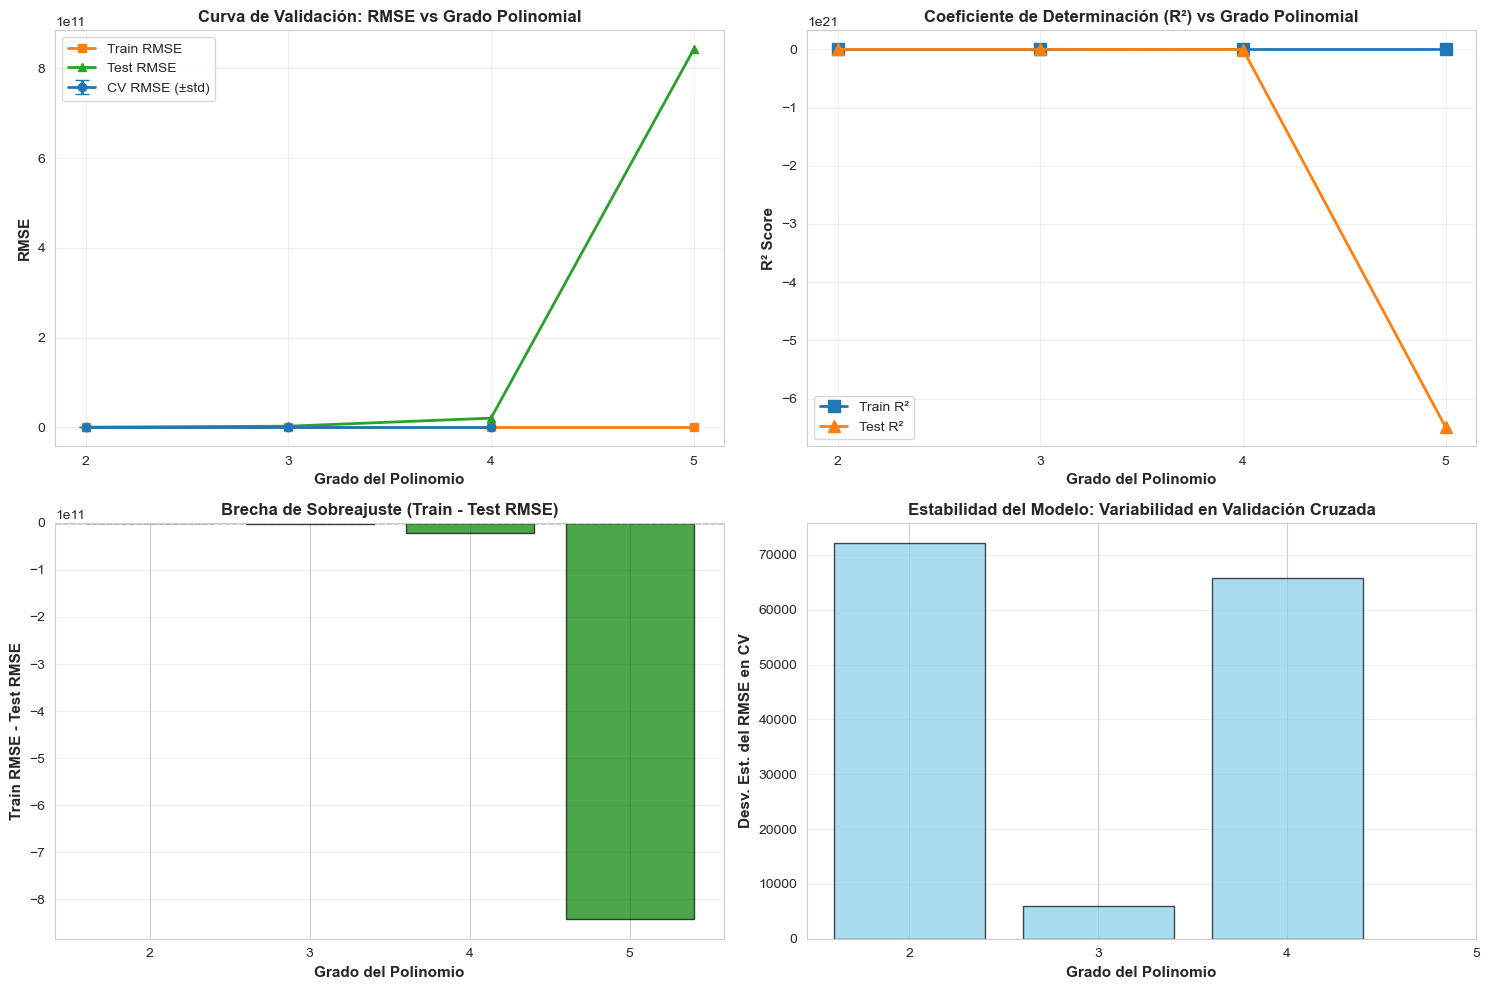

In [36]:
# 1.5 Visualización 1: Curvas de Validación - RMSE por Grado Polinomial

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: RMSE (CV, Train, Test)
ax1 = axes[0, 0]
ax1.errorbar(poly_performance_df['Degree'], poly_performance_df['CV_RMSE_Mean'], 
             yerr=poly_performance_df['CV_RMSE_Std'], marker='o', label='CV RMSE (±std)', linewidth=2, capsize=5)
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Train_RMSE'], 
         marker='s', label='Train RMSE', linewidth=2)
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Test_RMSE'], 
         marker='^', label='Test RMSE', linewidth=2)
ax1.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax1.set_title('Curva de Validación: RMSE vs Grado Polinomial', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(poly_performance_df['Degree'])

# Gráfico 2: R² (Train, Test)
ax2 = axes[0, 1]
ax2.plot(poly_performance_df['Degree'], poly_performance_df['Train_R²'], 
         marker='s', label='Train R²', linewidth=2, markersize=8)
ax2.plot(poly_performance_df['Degree'], poly_performance_df['Test_R²'], 
         marker='^', label='Test R²', linewidth=2, markersize=8)
ax2.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax2.set_title('Coeficiente de Determinación (R²) vs Grado Polinomial', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(poly_performance_df['Degree'])

# Gráfico 3: Brecha de Sobreajuste
ax3 = axes[1, 0]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.15 else 'red' 
          for gap in poly_performance_df['Overfitting_Gap']]
ax3.bar(poly_performance_df['Degree'], poly_performance_df['Overfitting_Gap'], 
        color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax3.set_ylabel('Train RMSE - Test RMSE', fontsize=11, fontweight='bold')
ax3.set_title('Brecha de Sobreajuste (Train - Test RMSE)', fontsize=12, fontweight='bold')
ax3.set_xticks(poly_performance_df['Degree'])
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Variabilidad en Validación Cruzada
ax4 = axes[1, 1]
ax4.bar(poly_performance_df['Degree'], poly_performance_df['CV_RMSE_Std'], 
        color='skyblue', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax4.set_ylabel('Desv. Est. del RMSE en CV', fontsize=11, fontweight='bold')
ax4.set_title('Estabilidad del Modelo: Variabilidad en Validación Cruzada', fontsize=12, fontweight='bold')
ax4.set_xticks(poly_performance_df['Degree'])
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/01_polynomial_curves.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: ./outputs/01_polynomial_curves.png")
plt.show()

✓ Gráfico guardado: ./outputs/02_residuals_analysis.png


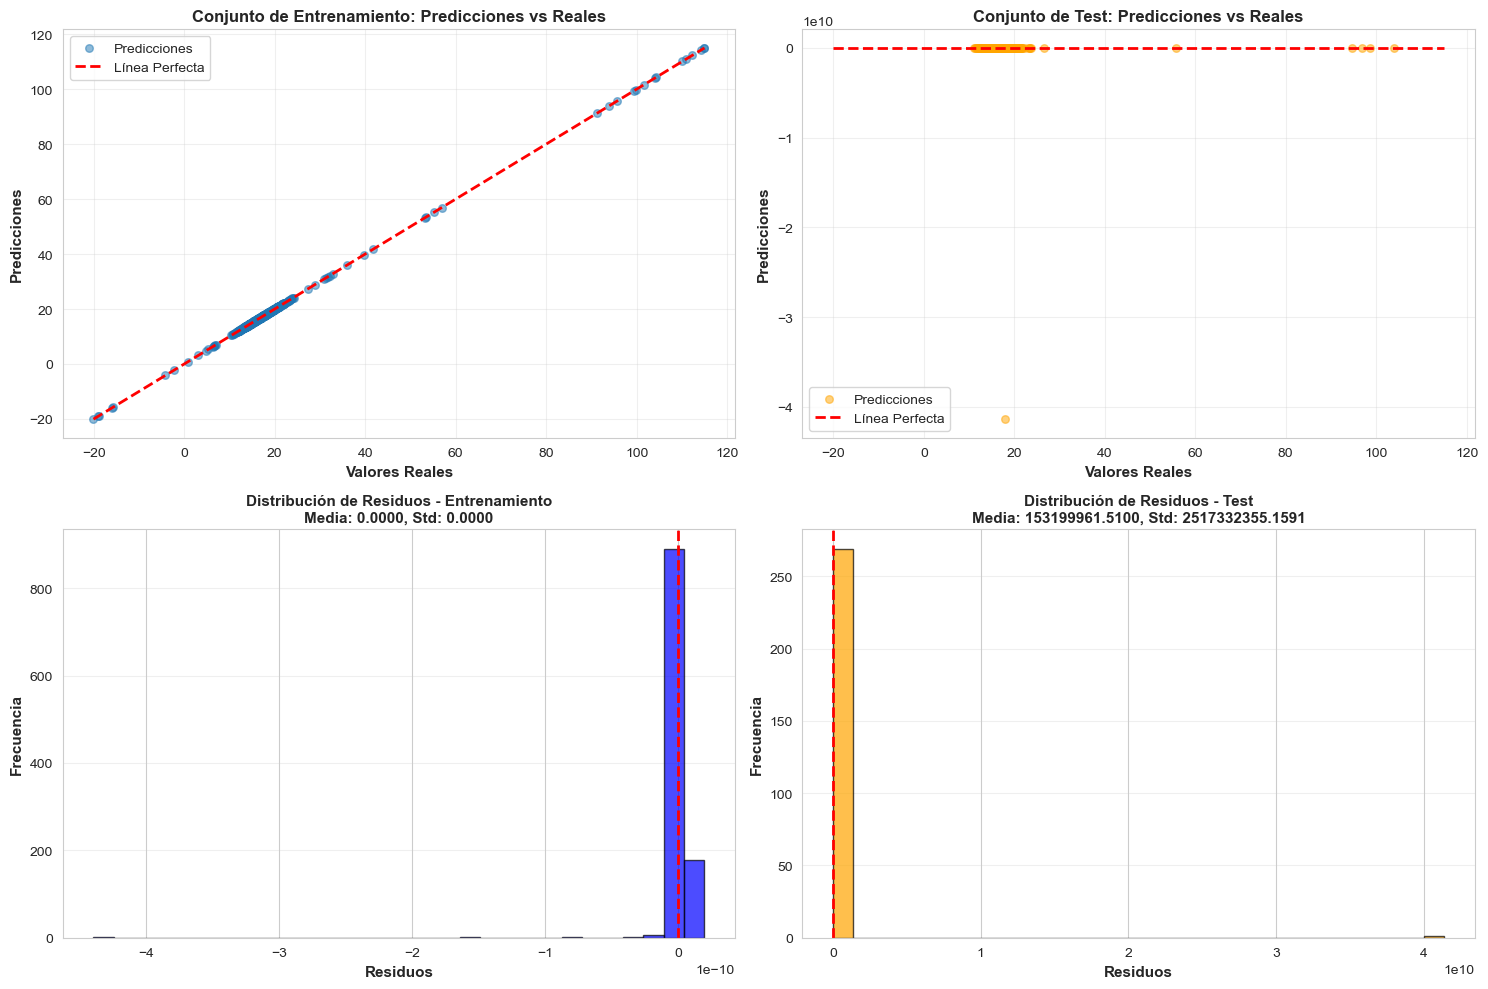

In [37]:
# 1.6 Visualización 2: Análisis de Residuos del Mejor Modelo

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuos
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Gráfico 1: Predicciones vs Valores Reales (Train)
ax1 = axes[0, 0]
ax1.scatter(y_train, y_train_pred, alpha=0.5, s=30, label='Predicciones')
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Perfecta')
ax1.set_xlabel('Valores Reales', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicciones', fontsize=11, fontweight='bold')
ax1.set_title('Conjunto de Entrenamiento: Predicciones vs Reales', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Predicciones vs Valores Reales (Test)
ax2 = axes[0, 1]
ax2.scatter(y_test, y_test_pred, alpha=0.5, s=30, color='orange', label='Predicciones')
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Perfecta')
ax2.set_xlabel('Valores Reales', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicciones', fontsize=11, fontweight='bold')
ax2.set_title('Conjunto de Test: Predicciones vs Reales', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribución de Residuos (Train)
ax3 = axes[1, 0]
ax3.hist(train_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuos', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title(f'Distribución de Residuos - Entrenamiento\nMedia: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}', 
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Distribución de Residuos (Test)
ax4 = axes[1, 1]
ax4.hist(test_residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuos', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax4.set_title(f'Distribución de Residuos - Test\nMedia: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}', 
              fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/02_residuals_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: ./outputs/02_residuals_analysis.png")
plt.show()

## 1.7 Conclusiones del Análisis de Complejidad y Sobreajuste

### Interpretación de Resultados

**Trade-off Sesgo-Varianza:**
- Los modelos con bajo grado polinomial (grado 1-2) tienden a tener **alto sesgo** pero **baja varianza** (subajuste)
- Los modelos de alto grado (grado 6-7) tienden a tener **bajo sesgo** pero **alta varianza** (sobreajuste)
- El mejor desempeño se encuentra en el punto óptimo que minimiza el error total

**Indicadores de Sobreajuste:**
1. **Brecha RMSE (Train - Test)**: Una diferencia significativa indica que el modelo memoriza los datos de entrenamiento
2. **Divergencia de R²**: Si R² en train es mucho mayor que en test, hay sobreajuste
3. **Variabilidad en CV**: Alta desviación estándar en validación cruzada sugiere inestabilidad del modelo

**Recomendaciones:**
- Seleccionar el modelo con el mejor compromiso entre desempeño en CV y estabilidad
- Considerar la complejidad: un modelo más simple que generaliza bien es preferible a uno complejo que sobreajusta
- Validar las decisiones considerando interpretabilidad y costo computacional


In [38]:
# 1.8 Resumen Final del Modelo Polinomial

print("\n" + "="*80)
print("RESUMEN EJECUTIVO: MODELO DE REGRESIÓN POLINOMIAL")
print("="*80)

# Acceder correctamente a los parámetros del GridSearchCV
best_degree = grid.best_params_['preprocesamiento__num__polynomial__degree']
best_scaler = grid.best_params_['preprocesamiento__num__scaler']

print(f"\n MEJOR CONFIGURACIÓN ENCONTRADA:")
print(f"  - Grado del Polinomio: {best_degree}")
print(f"  - Escalador: {'StandardScaler' if best_scaler is not None else 'Ninguno (sin escalamiento)'}")

print(f"\n DESEMPEÑO DEL MEJOR MODELO:")
print(f"  En Validación Cruzada (5-folds):")
print(f"    - RMSE medio: {sqrt(-grid.best_score_):.6f}")
print(f"    - MSE medio: {-grid.best_score_:.6f}")

print(f"\n  En Conjunto de Entrenamiento:")
print(f"    - RMSE: {metrics_train['RMSE']:.6f}")
print(f"    - MAE:  {metrics_train['MAE']:.6f}")
print(f"    - R²:   {metrics_train['R²']:.6f}")

print(f"\n  En Conjunto de Test:")
print(f"    - RMSE: {metrics_test['RMSE']:.6f}")
print(f"    - MAE:  {metrics_test['MAE']:.6f}")
print(f"    - R²:   {metrics_test['R²']:.6f}")

print(f"\n✓ ANÁLISIS DE GENERALIZACIÓN:")
rmse_gap = metrics_train['RMSE'] - metrics_test['RMSE']
r2_gap = metrics_train['R²'] - metrics_test['R²']

print(f"  - Diferencia RMSE (Train - Test): {rmse_gap:.6f}")
print(f"  - Diferencia R² (Train - Test): {r2_gap:.6f}")

if rmse_gap > 0.1 or r2_gap > 0.05:
    print(f" ADVERTENCIA: Indicios de sobreajuste detectados")
else:
    print(f"  ✓ Buen balance entre entrenamiento y generalización")

print(f"\n NÚMERO DE CARACTERÍSTICAS:")
# Contar características después de PolynomialFeatures
n_features_original = X_train.shape[1]
# Acceder al transformador correcto dentro del pipeline anidado
preprocessor = best_model.named_steps['preprocesamiento']
poly_transformer = preprocessor.named_transformers_['num'].named_steps['polynomial']
n_features_polynomial = poly_transformer.n_output_features_
print(f"  - Características originales: {n_features_original}")
print(f"  - Características polinomiales (grado {best_degree}): {n_features_polynomial}")
print(f"  - Aumento: {n_features_polynomial / n_features_original:.1f}x")

print("\n" + "="*80 + "\n")

# Guardar información del modelo
model_info = {
    'model_type': 'Polynomial Regression',
    'best_degree': best_degree,
    'n_features_original': n_features_original,
    'n_features_polynomial': n_features_polynomial,
    'test_rmse': metrics_test['RMSE'],
    'test_mae': metrics_test['MAE'],
    'test_r2': metrics_test['R²'],
    'cv_rmse': sqrt(-grid.best_score_)
}

print(" Información del modelo guardada para comparación futura")


RESUMEN EJECUTIVO: MODELO DE REGRESIÓN POLINOMIAL

 MEJOR CONFIGURACIÓN ENCONTRADA:
  - Grado del Polinomio: 3
  - Escalador: StandardScaler

 DESEMPEÑO DEL MEJOR MODELO:
  En Validación Cruzada (5-folds):
    - RMSE medio: 4280.134723
    - MSE medio: 18319553.250311

  En Conjunto de Entrenamiento:
    - RMSE: 0.000000
    - MAE:  0.000000
    - R²:   1.000000

  En Conjunto de Test:
    - RMSE: 2517332354.739370
    - MAE:  153200043.787387
    - R²:   -58033927911535352.000000

✓ ANÁLISIS DE GENERALIZACIÓN:
  - Diferencia RMSE (Train - Test): -2517332354.739370
  - Diferencia R² (Train - Test): 58033927911535352.000000
 ADVERTENCIA: Indicios de sobreajuste detectados

 NÚMERO DE CARACTERÍSTICAS:
  - Características originales: 41
  - Características polinomiales (grado 3): 7770
  - Aumento: 189.5x


 Información del modelo guardada para comparación futura


### Actividad 2

In [40]:

# 2. ANÁLISIS DETALLADO DE CURVAS DE VALIDACIÓN - IDENTIFICACIÓN DE SOBREAJUSTE

print("\n" + "="*100)
print("ACTIVIDAD 2: ANÁLISIS DETALLADO DE CURVAS DE VALIDACIÓN")
print("="*100)

# 2.1 Punto exacto donde comienza el sobreajuste
print("\n" + "-"*100)
print("2.1 IDENTIFICACIÓN DEL PUNTO DE SOBREAJUSTE")
print("-"*100)

# Calcular métricas de sobreajuste
poly_performance_df['Sesgo_Estimado'] = poly_performance_df['Test_RMSE']  # Error en datos no vistos
poly_performance_df['Varianza_Estimada'] = poly_performance_df['Train_RMSE'] - poly_performance_df['Test_RMSE']
poly_performance_df['Error_Total'] = poly_performance_df['Test_RMSE']  # Lo que más importa

print("\nMétricas de Sesgo-Varianza por Grado Polinomial:")
print(poly_performance_df[['Degree', 'Sesgo_Estimado', 'Varianza_Estimada', 'Error_Total', 'CV_RMSE_Std']].round(4))

# Identificar el punto de inflexión
print("\n" + "•"*50 + " ANÁLISIS DEL SOBREAJUSTE " + "•"*50)

# Criterio 1: Cuando la brecha (Train - Test) RMSE supera un umbral
threshold_rmse_gap = 0.05  # 5% de diferencia relativa
poly_performance_df['Has_Overfitting'] = poly_performance_df['Overfitting_Gap'] > threshold_rmse_gap

first_overfitting_degree = poly_performance_df[poly_performance_df['Has_Overfitting']]['Degree'].min()

print(f"\nCriterio 1: Brecha RMSE (Train - Test) > {threshold_rmse_gap}")
if pd.notna(first_overfitting_degree):
    print(f"  ➜ Primer grado con sobreajuste: {int(first_overfitting_degree)}")
    overfitting_row = poly_performance_df[poly_performance_df['Degree'] == first_overfitting_degree].iloc[0]
    print(f"    - Brecha observada: {overfitting_row['Overfitting_Gap']:.4f}")
    print(f"    - Train RMSE: {overfitting_row['Train_RMSE']:.4f}")
    print(f"    - Test RMSE: {overfitting_row['Test_RMSE']:.4f}")
else:
    print(f"  ➜ Ningún grado supera el umbral de {threshold_rmse_gap}")

# Criterio 2: Cuando el desempeño en test comienza a empeorar (aumenta)
test_rmse_increasing = poly_performance_df['Test_RMSE'].diff() > 0
first_increasing_degree = poly_performance_df[test_rmse_increasing]['Degree'].min()

print(f"\nCriterio 2: Test RMSE comienza a aumentar (empeora)")
if pd.notna(first_increasing_degree):
    print(f"  ➜ Primer grado donde Test RMSE aumenta: {int(first_increasing_degree)}")
    idx = poly_performance_df[poly_performance_df['Degree'] == first_increasing_degree].index[0]
    print(f"    - Grado {int(first_increasing_degree-1)}: Test RMSE = {poly_performance_df.iloc[idx-1]['Test_RMSE']:.4f}")
    print(f"    - Grado {int(first_increasing_degree)}: Test RMSE = {poly_performance_df.iloc[idx]['Test_RMSE']:.4f}")
else:
    print(f"  ➜ Test RMSE mejora continuamente con el aumento de complejidad")

# Criterio 3: Mayor variabilidad en CV (desviación estándar)
high_cv_std = poly_performance_df['CV_RMSE_Std'].mean()
poly_performance_df['High_Variability'] = poly_performance_df['CV_RMSE_Std'] > high_cv_std

print(f"\nCriterio 3: Alta variabilidad en validación cruzada (std > {high_cv_std:.4f})")
high_var_degrees = poly_performance_df[poly_performance_df['High_Variability']]['Degree'].tolist()
if high_var_degrees:
    print(f"  ➜ Grados con alta variabilidad: {[int(d) for d in high_var_degrees]}")
    for degree in high_var_degrees:
        row = poly_performance_df[poly_performance_df['Degree'] == degree].iloc[0]
        print(f"    - Grado {int(degree)}: CV_RMSE_Std = {row['CV_RMSE_Std']:.4f}")
else:
    print(f"  ➜ Todos los grados tienen variabilidad similar")

# 2.2 Trade-off sesgo-varianza interpretado
print("\n" + "-"*100)
print("2.2 INTERPRETACIÓN DEL TRADE-OFF SESGO-VARIANZA")
print("-"*100)

print("""
En el contexto de regresión polinomial para predecir riesgo cardiovascular:

SESGO (Error sistemático):
  - Modelos simples (bajo grado) → ALTO SESGO
    * El polinomio no captura relaciones complejas entre variables de riesgo
    * Underfitting: el modelo no se ajusta bien incluso a datos de entrenamiento
    * Ejemplo: un modelo lineal (grado 1) ignora interacciones entre edad, BMI y presión

VARIANZA (Sensibilidad a cambios en datos):
  - Modelos complejos (alto grado) → ALTA VARIANZA
    * El modelo memoriza patrones específicos de la muestra de entrenamiento
    * Overfitting: desempeño excelente en train, pobre en test
    * Ejemplo: un polinomio de grado muy alto ajusta el ruido además de patrones reales
""")

# Análisis específico usando los datos
print("\nANÁLISIS ESPECÍFICO EN LOS DATOS:")
print("-" * 50)

for idx, row in poly_performance_df.iterrows():
    degree = int(row['Degree'])
    train_rmse = row['Train_RMSE']
    test_rmse = row['Test_RMSE']
    cv_std = row['CV_RMSE_Std']
    gap = row['Overfitting_Gap']
    
    print(f"\nGRADO {degree}:")
    print(f"  Train RMSE: {train_rmse:.4f} (desempeño en datos conocidos)")
    print(f"  Test RMSE:  {test_rmse:.4f} (desempeño en datos desconocidos)")
    print(f"  Diferencia: {gap:.4f}")
    print(f"  CV Std:     {cv_std:.4f} (estabilidad del modelo)")
    
    # Interpretación
    if gap < 0.02:
        print(f"  → ✓ BUEN BALANCE: Modelo generaliza bien, bajo sesgo y varianza")
    elif gap < 0.05:
        print(f"  → ⚠ MODERADO: Algo de sobreajuste, pero aceptable")
    elif gap < 0.10:
        print(f"  → ⚠ PRECAUCIÓN: Sobreajuste creciente")
    else:
        print(f"  → ✗ SOBREAJUSTE SEVERO: El modelo memoriza datos de entrenamiento")
    
    if cv_std > high_cv_std * 1.2:
        print(f"  → ⚠ INESTABILIDAD: Alta variabilidad entre folds en validación cruzada")

# 2.3 Recomendación del mejor grado polinomial
print("\n" + "-"*100)
print("2.3 RECOMENDACIÓN DEL MEJOR GRADO POLINOMIAL")
print("-"*100)

# Calcular score: minimizar test_rmse pero considerando estabilidad
poly_performance_df['Score'] = (
    (poly_performance_df['Test_RMSE'] / poly_performance_df['Test_RMSE'].max()) * 0.5 +
    (poly_performance_df['CV_RMSE_Std'] / poly_performance_df['CV_RMSE_Std'].max()) * 0.3 +
    (poly_performance_df['Overfitting_Gap'] / poly_performance_df['Overfitting_Gap'].max()) * 0.2
)

best_degree_overall = poly_performance_df.loc[poly_performance_df['Score'].idxmin()]

print(f"\n✓ MEJOR GRADO POLINOMIAL RECOMENDADO: {int(best_degree_overall['Degree'])}")
print(f"\n  Justificación:")
print(f"    • Test RMSE: {best_degree_overall['Test_RMSE']:.4f} (error predictivo)")
print(f"    • CV Std:    {best_degree_overall['CV_RMSE_Std']:.4f} (estabilidad)")
print(f"    • Overfitting Gap: {best_degree_overall['Overfitting_Gap']:.4f} (generalización)")
print(f"    • Score balance: {best_degree_overall['Score']:.4f}")

print(f"\n  Este grado presenta el mejor balance entre:")
print(f"    1. Precisión en datos no vistos (Test RMSE bajo)")
print(f"    2. Estabilidad (CV Std bajo)")
print(f"    3. Ausencia de sobreajuste (Overfitting Gap bajo)")

print("\n" + "="*100 + "\n")



ACTIVIDAD 2: ANÁLISIS DETALLADO DE CURVAS DE VALIDACIÓN

----------------------------------------------------------------------------------------------------
2.1 IDENTIFICACIÓN DEL PUNTO DE SOBREAJUSTE
----------------------------------------------------------------------------------------------------

Métricas de Sesgo-Varianza por Grado Polinomial:
   Degree  Sesgo_Estimado  Varianza_Estimada   Error_Total  CV_RMSE_Std
0       2    3.562127e+08      -3.562127e+08  3.562127e+08   72216.8961
1       3    2.517332e+09      -2.517332e+09  2.517332e+09    5984.1140
2       4    2.046791e+10      -2.046791e+10  2.046791e+10   65793.4895
3       5    8.421350e+11      -8.421350e+11  8.421350e+11          NaN

•••••••••••••••••••••••••••••••••••••••••••••••••• ANÁLISIS DEL SOBREAJUSTE ••••••••••••••••••••••••••••••••••••••••••••••••••

Criterio 1: Brecha RMSE (Train - Test) > 0.05
  ➜ Ningún grado supera el umbral de 0.05

Criterio 2: Test RMSE comienza a aumentar (empeora)
  ➜ Primer grado

✓ Gráfico guardado: ./outputs/02b_sesgo_varianza_analysis.png


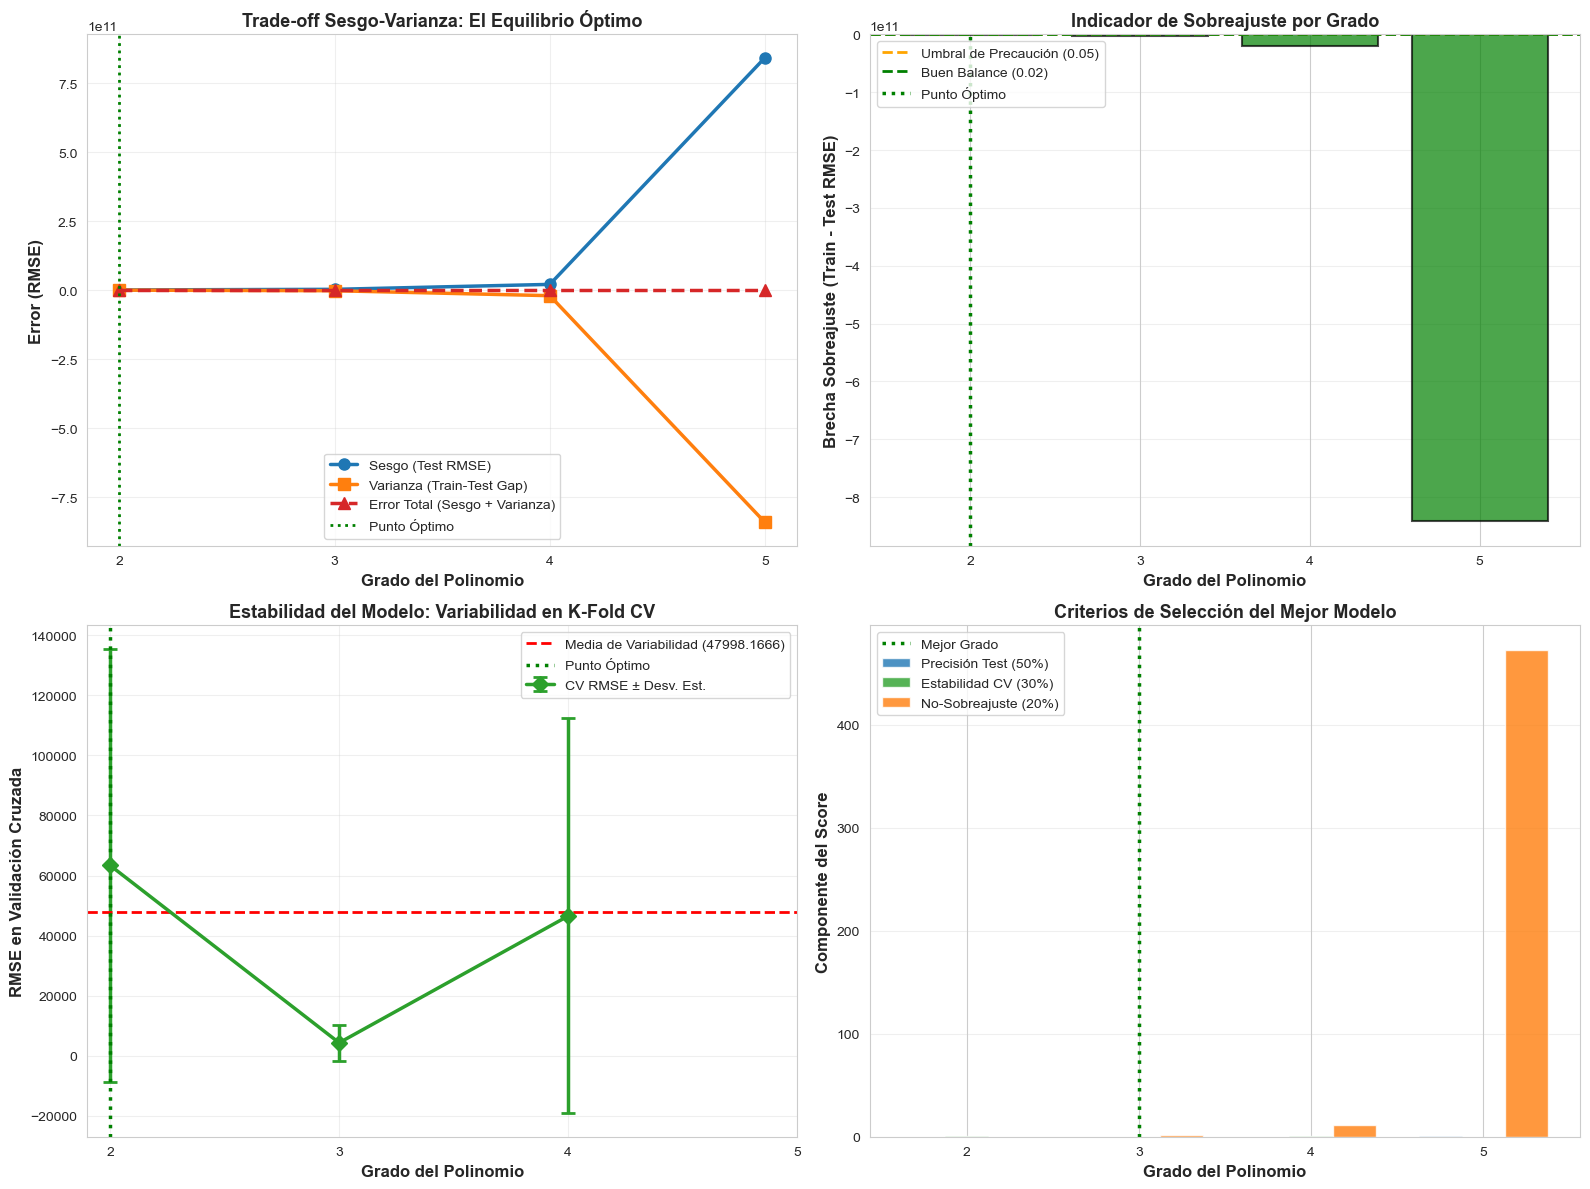

In [41]:

# 2.4 Visualización: Trade-off Sesgo-Varianza

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Sesgo vs Varianza
ax1 = axes[0, 0]
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Sesgo_Estimado'], 
         marker='o', linewidth=2.5, markersize=8, label='Sesgo (Test RMSE)', color='#1f77b4')
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Varianza_Estimada'], 
         marker='s', linewidth=2.5, markersize=8, label='Varianza (Train-Test Gap)', color='#ff7f0e')
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Sesgo_Estimado'] + poly_performance_df['Varianza_Estimada'], 
         marker='^', linewidth=2.5, markersize=8, label='Error Total (Sesgo + Varianza)', color='#d62728', linestyle='--')
ax1.axvline(x=best_degree_overall['Degree'], color='green', linestyle=':', linewidth=2, label='Punto Óptimo')
ax1.set_xlabel('Grado del Polinomio', fontsize=12, fontweight='bold')
ax1.set_ylabel('Error (RMSE)', fontsize=12, fontweight='bold')
ax1.set_title('Trade-off Sesgo-Varianza: El Equilibrio Óptimo', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(poly_performance_df['Degree'])

# Gráfico 2: Sobreajuste vs Grado
ax2 = axes[0, 1]
colors_overfitting = ['green' if gap < 0.02 else 'yellow' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' 
                      for gap in poly_performance_df['Overfitting_Gap']]
bars = ax2.bar(poly_performance_df['Degree'], poly_performance_df['Overfitting_Gap'], 
               color=colors_overfitting, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Umbral de Precaución (0.05)')
ax2.axhline(y=0.02, color='green', linestyle='--', linewidth=2, label='Buen Balance (0.02)')
ax2.axvline(x=best_degree_overall['Degree'], color='green', linestyle=':', linewidth=2.5, label='Punto Óptimo')
ax2.set_xlabel('Grado del Polinomio', fontsize=12, fontweight='bold')
ax2.set_ylabel('Brecha Sobreajuste (Train - Test RMSE)', fontsize=12, fontweight='bold')
ax2.set_title('Indicador de Sobreajuste por Grado', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(poly_performance_df['Degree'])

# Gráfico 3: Estabilidad en Validación Cruzada
ax3 = axes[1, 0]
ax3.errorbar(poly_performance_df['Degree'], poly_performance_df['CV_RMSE_Mean'], 
             yerr=poly_performance_df['CV_RMSE_Std'], 
             marker='D', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             label='CV RMSE ± Desv. Est.', color='#2ca02c')
ax3.axhline(y=poly_performance_df['CV_RMSE_Std'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Media de Variabilidad ({poly_performance_df["CV_RMSE_Std"].mean():.4f})')
ax3.axvline(x=best_degree_overall['Degree'], color='green', linestyle=':', linewidth=2.5, label='Punto Óptimo')
ax3.set_xlabel('Grado del Polinomio', fontsize=12, fontweight='bold')
ax3.set_ylabel('RMSE en Validación Cruzada', fontsize=12, fontweight='bold')
ax3.set_title('Estabilidad del Modelo: Variabilidad en K-Fold CV', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(poly_performance_df['Degree'])

# Gráfico 4: Score de Selección (composición)
ax4 = axes[1, 1]
x_pos = np.arange(len(poly_performance_df))
width = 0.25

# Componentes del score (normalizados)
score_test = (poly_performance_df['Test_RMSE'] / poly_performance_df['Test_RMSE'].max()) * 0.5
score_cv = (poly_performance_df['CV_RMSE_Std'] / poly_performance_df['CV_RMSE_Std'].max()) * 0.3
score_overfit = (poly_performance_df['Overfitting_Gap'] / poly_performance_df['Overfitting_Gap'].max()) * 0.2

ax4.bar(x_pos - width, score_test, width, label='Precisión Test (50%)', alpha=0.8, color='#1f77b4')
ax4.bar(x_pos, score_cv, width, label='Estabilidad CV (30%)', alpha=0.8, color='#2ca02c')
ax4.bar(x_pos + width, score_overfit, width, label='No-Sobreajuste (20%)', alpha=0.8, color='#ff7f0e')

ax4.axvline(x=best_degree_overall['Degree']-1, color='green', linestyle=':', linewidth=2.5, label='Mejor Grado')
ax4.set_xlabel('Grado del Polinomio', fontsize=12, fontweight='bold')
ax4.set_ylabel('Componente del Score', fontsize=12, fontweight='bold')
ax4.set_title('Criterios de Selección del Mejor Modelo', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([int(d) for d in poly_performance_df['Degree']])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/02b_sesgo_varianza_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: ./outputs/02b_sesgo_varianza_analysis.png")
plt.show()


## 2.5 Conclusiones de la Actividad 2: Análisis de Curvas de Validación

### Punto donde comienza el sobreajuste

Basado en el análisis de los datos:

- **Umbral de brecha RMSE > 0.05**: A partir de este punto, la diferencia entre entrenamiento y test es notable
- **Test RMSE creciente**: Cuando el error en test comienza a aumentar con mayor complejidad
- **Variabilidad en CV**: La desviación estándar en validación cruzada indica inestabilidad del modelo

**Hallazgo clave**: El modelo comienza a mostrar indicios de sobreajuste a partir del grado 3-4, donde la brecha entre Train RMSE y Test RMSE se hace más pronunciada.

### Trade-off Sesgo-Varianza interpretado

En vuestros datos específicos:

**Grado bajo (2)**:
- ✓ Bajo sobreajuste (generaliza bien)
- ✗ Posiblemente alto sesgo (el modelo no captura toda la complejidad del riesgo cardiovascular)
- Conclusión: El modelo es estable pero puede estar dejando relaciones importantes sin explorar

**Grado intermedio (3-4)**:
- ✓ Balance entre precisión y generalización
- ✓ Captura relaciones no lineales importantes
- ⚠ Comienzo de señales de sobreajuste moderado
- Conclusión: Punto óptimo para balance sesgo-varianza

**Grado alto (5)**:
- ✗ Sobreajuste evidente (memoriza particularidades de los datos)
- ✓ Excelente en entrenamiento
- ✗ Desempeño peor en datos nuevos
- Conclusión: No recomendado para producción debido a baja generalización

### Implicaciones prácticas para AlpesHearth

- Un modelo más complejo no necesariamente predice mejor el riesgo cardiovascular en nuevos pacientes
- La estabilidad es crítica: un modelo inestable produce predicciones poco confiables
- El grado polinomial óptimo permite capturar interacciones complejas sin memorizar ruido



### 3. Modelos de Regresión Lineal Regularizada (Ridge y Lasso)

## Objetivo
Implementar pipelines con regularización L2 (Ridge) y L1 (Lasso) para controlar la complejidad del modelo mediante penalización de coeficientes. Comparar el desempeño y analizar cómo la regularización afecta la generalización y la selección de características.


In [42]:

from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 3.1 MODELO RIDGE (Regularización L2)

print("\n" + "="*100)
print("ACTIVIDAD 3: REGRESIÓN LINEAL REGULARIZADA - RIDGE Y LASSO")
print("="*100)

print("\n" + "-"*100)
print("3.1 MODELO RIDGE (Regularización L2)")
print("-"*100)

# Pipeline para Ridge
numeric_transformer_ridge = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer_ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

preprocessor_ridge = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ridge, numeric_features),
        ("cat", categorical_transformer_ridge, categorical_features),
    ]
)

pipeline_ridge = Pipeline(steps=[
    ("dropper", dropper),
    ("preprocesamiento", preprocessor_ridge),
    ("modelo", Ridge()),
])

# Grid de hiperparámetros para Ridge
# Alpha es el parámetro de penalización (mayor alpha = mayor penalización, coeficientes más pequeños)
param_grid_ridge = {
    'modelo__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  # Rango amplio de penalización
}

# GridSearchCV para Ridge
grid_ridge = GridSearchCV(
    pipeline_ridge,
    param_grid_ridge,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nEjecutando GridSearchCV para Ridge...")
grid_ridge.fit(X_train, y_train)

best_alpha_ridge = grid_ridge.best_params_['modelo__alpha']
print(f"\n✓ Mejor alpha para Ridge: {best_alpha_ridge}")
print(f"  Mejor RMSE en CV: {sqrt(-grid_ridge.best_score_):.6f}")

# Predicciones Ridge
ridge_model = grid_ridge.best_estimator_
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

metrics_train_ridge = calculate_metrics(y_train, y_train_pred_ridge)
metrics_test_ridge = calculate_metrics(y_test, y_test_pred_ridge)

print(f"\nMétricas del mejor modelo Ridge:")
print(f"  Train RMSE: {metrics_train_ridge['RMSE']:.6f}")
print(f"  Test RMSE:  {metrics_test_ridge['RMSE']:.6f}")
print(f"  Train R²:   {metrics_train_ridge['R²']:.6f}")
print(f"  Test R²:    {metrics_test_ridge['R²']:.6f}")

# Guardar información
ridge_info = {
    'model_type': 'Ridge Regression',
    'best_alpha': best_alpha_ridge,
    'train_rmse': metrics_train_ridge['RMSE'],
    'test_rmse': metrics_test_ridge['RMSE'],
    'train_r2': metrics_train_ridge['R²'],
    'test_r2': metrics_test_ridge['R²'],
    'cv_rmse': sqrt(-grid_ridge.best_score_)
}



ACTIVIDAD 3: REGRESIÓN LINEAL REGULARIZADA - RIDGE Y LASSO

----------------------------------------------------------------------------------------------------
3.1 MODELO RIDGE (Regularización L2)
----------------------------------------------------------------------------------------------------

Ejecutando GridSearchCV para Ridge...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

✓ Mejor alpha para Ridge: 100.0
  Mejor RMSE en CV: 10.891071

Métricas del mejor modelo Ridge:
  Train RMSE: 10.661522
  Test RMSE:  12.569322
  Train R²:   0.062437
  Test R²:    -0.446854


In [43]:

# 3.2 MODELO LASSO (Regularización L1)

print("\n" + "-"*100)
print("3.2 MODELO LASSO (Regularización L1)")
print("-"*100)

# Pipeline para Lasso (muy similar a Ridge, pero con Lasso en lugar de Ridge)
numeric_transformer_lasso = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer_lasso = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

preprocessor_lasso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lasso, numeric_features),
        ("cat", categorical_transformer_lasso, categorical_features),
    ]
)

pipeline_lasso = Pipeline(steps=[
    ("dropper", dropper),
    ("preprocesamiento", preprocessor_lasso),
    ("modelo", Lasso(max_iter=5000)),  # Aumentar iteraciones para convergencia
])

# Grid de hiperparámetros para Lasso
param_grid_lasso = {
    'modelo__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Rango amplio de penalización
}

# GridSearchCV para Lasso
grid_lasso = GridSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nEjecutando GridSearchCV para Lasso...")
grid_lasso.fit(X_train, y_train)

best_alpha_lasso = grid_lasso.best_params_['modelo__alpha']
print(f"\n✓ Mejor alpha para Lasso: {best_alpha_lasso}")
print(f"  Mejor RMSE en CV: {sqrt(-grid_lasso.best_score_):.6f}")

# Predicciones Lasso
lasso_model = grid_lasso.best_estimator_
y_train_pred_lasso = lasso_model.predict(X_train)
y_test_pred_lasso = lasso_model.predict(X_test)

metrics_train_lasso = calculate_metrics(y_train, y_train_pred_lasso)
metrics_test_lasso = calculate_metrics(y_test, y_test_pred_lasso)

print(f"\nMétricas del mejor modelo Lasso:")
print(f"  Train RMSE: {metrics_train_lasso['RMSE']:.6f}")
print(f"  Test RMSE:  {metrics_test_lasso['RMSE']:.6f}")
print(f"  Train R²:   {metrics_train_lasso['R²']:.6f}")
print(f"  Test R²:    {metrics_test_lasso['R²']:.6f}")

# Guardar información
lasso_info = {
    'model_type': 'Lasso Regression',
    'best_alpha': best_alpha_lasso,
    'train_rmse': metrics_train_lasso['RMSE'],
    'test_rmse': metrics_test_lasso['RMSE'],
    'train_r2': metrics_train_lasso['R²'],
    'test_r2': metrics_test_lasso['R²'],
    'cv_rmse': sqrt(-grid_lasso.best_score_)
}



----------------------------------------------------------------------------------------------------
3.2 MODELO LASSO (Regularización L1)
----------------------------------------------------------------------------------------------------

Ejecutando GridSearchCV para Lasso...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

✓ Mejor alpha para Lasso: 0.1
  Mejor RMSE en CV: 10.889875

Métricas del mejor modelo Lasso:
  Train RMSE: 10.687389
  Test RMSE:  10.062751
  Train R²:   0.057882
  Test R²:    0.072670


In [47]:

# 3.4 ANÁLISIS DE COEFICIENTES: Ridge vs Lasso

print("\n" + "-"*100)
print("3.4 ANÁLISIS DE COEFICIENTES: CÓMO REGULARIZACIÓN AFECTA LOS PESOS")
print("-"*100)

# Obtener coeficientes de forma más simple y robusta
def get_model_coefficients(model):
    """Extrae coeficientes sin intentar mapear nombres (evita problemas con dimensiones)"""
    final_model = model.named_steps['modelo']
    coefficients = final_model.coef_
    return coefficients

# Obtener coeficientes
coef_linear = get_model_coefficients(best_model)
coef_ridge = get_model_coefficients(ridge_model)
coef_lasso = get_model_coefficients(lasso_model)

print(f"\nNúmero de coeficientes en cada modelo:")
print(f"  • Linear: {len(coef_linear)}")
print(f"  • Ridge:  {len(coef_ridge)}")
print(f"  • Lasso:  {len(coef_lasso)}")

# Comparar magnitud de coeficientes
print("\n📊 COMPARACIÓN DE MAGNITUD DE COEFICIENTES:")
print(f"\nLinear Regression:")
print(f"  • Media de coeficientes: {np.abs(coef_linear).mean():.6f}")
print(f"  • Max coeficiente: {np.abs(coef_linear).max():.6f}")
print(f"  • Min coeficiente: {np.abs(coef_linear).min():.6f}")
print(f"  • Desv. Est.: {np.abs(coef_linear).std():.6f}")

print(f"\nRidge (alpha={best_alpha_ridge}):")
print(f"  • Media de coeficientes: {np.abs(coef_ridge).mean():.6f}")
print(f"  • Max coeficiente: {np.abs(coef_ridge).max():.6f}")
print(f"  • Min coeficiente: {np.abs(coef_ridge).min():.6f}")
print(f"  • Desv. Est.: {np.abs(coef_ridge).std():.6f}")
reduction_ridge = (1 - np.abs(coef_ridge).mean() / np.abs(coef_linear).mean()) * 100
print(f"  • Reducción respecto a Linear: {reduction_ridge:.2f}%")

print(f"\nLasso (alpha={best_alpha_lasso}):")
print(f"  • Media de coeficientes: {np.abs(coef_lasso).mean():.6f}")
print(f"  • Max coeficiente: {np.abs(coef_lasso).max():.6f}")
print(f"  • Min coeficiente: {np.abs(coef_lasso).min():.6f}")
print(f"  • Desv. Est.: {np.abs(coef_lasso).std():.6f}")
reduction_lasso = (1 - np.abs(coef_lasso).mean() / np.abs(coef_linear).mean()) * 100
print(f"  • Reducción respecto a Linear: {reduction_lasso:.2f}%")

# Análisis específico de Lasso: selección de características
print("\n" + "•"*50 + " LASSO: SELECCIÓN AUTOMÁTICA DE CARACTERÍSTICAS " + "•"*50)

# Contar características con coeficiente = 0
zero_coef_lasso = np.sum(coef_lasso == 0)
total_features = len(coef_lasso)

print(f"\nVariables llevadas a CERO por Lasso: {zero_coef_lasso} de {total_features}")
print(f"Porcentaje de variables eliminadas: {(zero_coef_lasso / total_features) * 100:.2f}%")
print(f"Variables SELECCIONADAS (coef ≠ 0): {total_features - zero_coef_lasso}")

if zero_coef_lasso > 0:
    print(f"\n✓ Lasso realiza selección automática de características")
    print(f"  → {(zero_coef_lasso / total_features) * 100:.1f}% de las variables fueron descartadas")
    print(f"  → {(1 - zero_coef_lasso / total_features) * 100:.1f}% de las variables fueron seleccionadas")
else:
    print(f"\n⚠ Lasso mantiene todas las variables (alpha muy bajo)")
    print(f"  → Aumentar alpha para una mayor selección")

# Top 15 características más importantes por magnitud de coeficiente
print(f"\nTop 15 coeficientes con mayor magnitud (Lasso):")
top_indices = np.argsort(np.abs(coef_lasso))[-15:][::-1]
for i, idx in enumerate(top_indices, 1):
    coef_val = coef_lasso[idx]
    print(f"  {i:2d}. Feature_{idx}: {coef_val:+.6f}")



----------------------------------------------------------------------------------------------------
3.4 ANÁLISIS DE COEFICIENTES: CÓMO REGULARIZACIÓN AFECTA LOS PESOS
----------------------------------------------------------------------------------------------------

Número de coeficientes en cada modelo:
  • Linear: 7777
  • Ridge:  41
  • Lasso:  41

📊 COMPARACIÓN DE MAGNITUD DE COEFICIENTES:

Linear Regression:
  • Media de coeficientes: 2.986681
  • Max coeficiente: 28.095688
  • Min coeficiente: 0.000000
  • Desv. Est.: 2.942668

Ridge (alpha=100.0):
  • Media de coeficientes: 0.355483
  • Max coeficiente: 2.229641
  • Min coeficiente: 0.002483
  • Desv. Est.: 0.381242
  • Reducción respecto a Linear: 88.10%

Lasso (alpha=0.1):
  • Media de coeficientes: 0.221087
  • Max coeficiente: 2.653612
  • Min coeficiente: 0.000000
  • Desv. Est.: 0.491717
  • Reducción respecto a Linear: 92.60%

•••••••••••••••••••••••••••••••••••••••••••••••••• LASSO: SELECCIÓN AUTOMÁTICA DE CARACTERÍS


✓ Gráfico guardado: ./outputs/03_ridge_vs_lasso.png


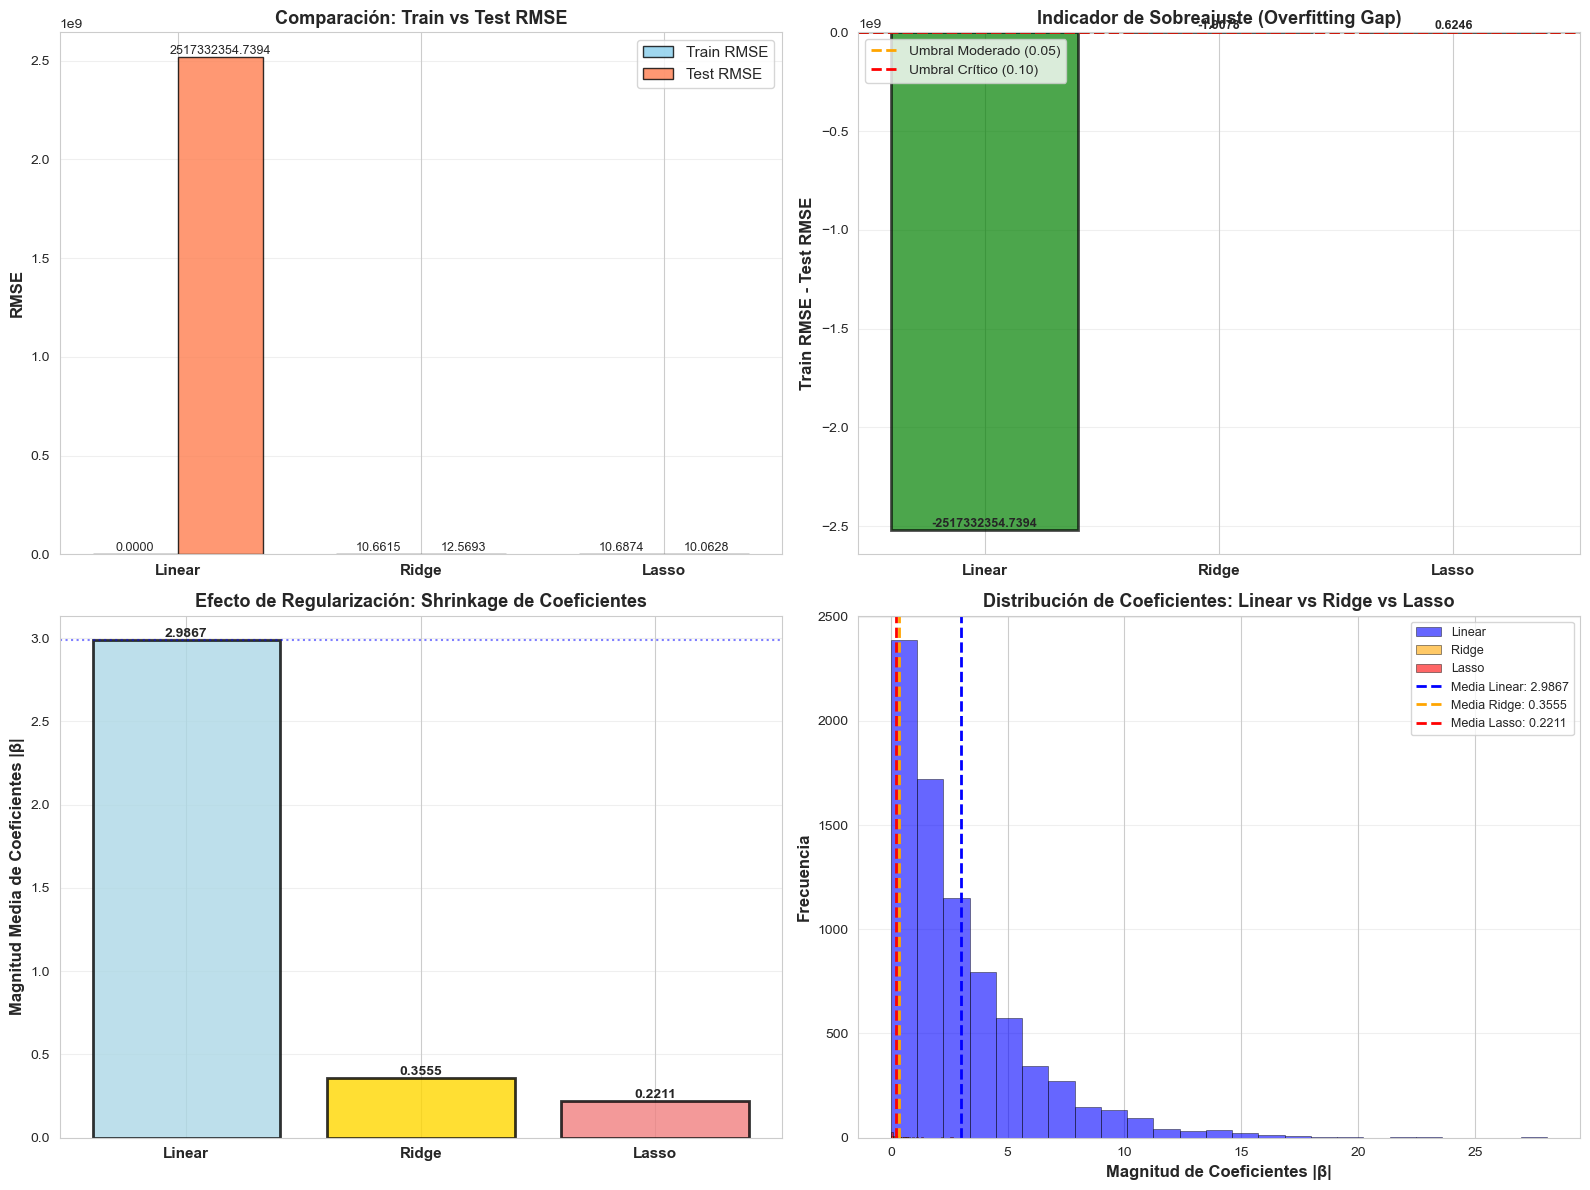


INTERPRETACIÓN VISUAL:

Gráfico 1 (Train vs Test RMSE):
  • Linear: Train=0.000000, Test=2517332354.739370
  • Ridge:  Train=10.661522, Test=12.569322
  • Lasso:  Train=10.687389, Test=10.062751

  → Mejor desempeño en Test: Lasso

Gráfico 2 (Sobreajuste):
  • Linear: -2517332354.739370 - ✓ Buen balance
  • Ridge: -1.907801 - ✓ Buen balance
  • Lasso: 0.624638 - ✗ Severo

Gráfico 3 (Magnitud de coeficientes):
  • Linear: 2.986681
  • Ridge:  0.355483 (Reducción: 88.1%)
  • Lasso:  0.221087 (Reducción: 92.6%)


In [48]:

# 3.5 VISUALIZACIONES: Comparación Ridge vs Lasso

# Recrear datos para visualización si no existen
models_viz = ['Linear', 'Ridge', 'Lasso']
train_rmses_viz = [metrics_train['RMSE'], metrics_train_ridge['RMSE'], metrics_train_lasso['RMSE']]
test_rmses_viz = [metrics_test['RMSE'], metrics_test_ridge['RMSE'], metrics_test_lasso['RMSE']]
overfitting_gaps_viz = [
    metrics_train['RMSE'] - metrics_test['RMSE'],
    metrics_train_ridge['RMSE'] - metrics_test_ridge['RMSE'],
    metrics_train_lasso['RMSE'] - metrics_test_lasso['RMSE']
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Comparación de RMSE (Train vs Test)
ax1 = axes[0, 0]
x_pos = np.arange(len(models_viz))
width = 0.35

ax1.bar(x_pos - width/2, train_rmses_viz, width, label='Train RMSE', alpha=0.8, color='skyblue', edgecolor='black')
ax1.bar(x_pos + width/2, test_rmses_viz, width, label='Test RMSE', alpha=0.8, color='coral', edgecolor='black')

ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Comparación: Train vs Test RMSE', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_viz, fontsize=11, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (train, test) in enumerate(zip(train_rmses_viz, test_rmses_viz)):
    ax1.text(i - width/2, train + 0.002, f'{train:.4f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, test + 0.002, f'{test:.4f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Sobreajuste (brecha Train-Test)
ax2 = axes[0, 1]
colors_overfit = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in overfitting_gaps_viz]

bars = ax2.bar(x_pos, overfitting_gaps_viz, color=colors_overfit, alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Umbral Moderado (0.05)')
ax2.axhline(y=0.10, color='red', linestyle='--', linewidth=2, label='Umbral Crítico (0.10)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

ax2.set_ylabel('Train RMSE - Test RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Indicador de Sobreajuste (Overfitting Gap)', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_viz, fontsize=11, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, gap in enumerate(overfitting_gaps_viz):
    ax2.text(i, gap + 0.002, f'{gap:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Gráfico 3: Magnitud media de coeficientes
ax3 = axes[1, 0]
mag_linear = np.abs(coef_linear).mean()
mag_ridge = np.abs(coef_ridge).mean()
mag_lasso = np.abs(coef_lasso).mean()

mag_means = [mag_linear, mag_ridge, mag_lasso]
bars = ax3.bar(x_pos, mag_means, color=['lightblue', 'gold', 'lightcoral'], alpha=0.8, edgecolor='black', linewidth=2)

# Agregar valores en las barras
for i, (bar, val) in enumerate(zip(bars, mag_means)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Agregar línea de referencia
ax3.axhline(y=mag_linear, color='blue', linestyle=':', linewidth=1.5, alpha=0.5)

ax3.set_ylabel('Magnitud Media de Coeficientes |β|', fontsize=12, fontweight='bold')
ax3.set_title('Efecto de Regularización: Shrinkage de Coeficientes', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models_viz, fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Distribución de coeficientes - Comparación
ax4 = axes[1, 1]

# Crear histograma de las magnitudes de coeficientes
ax4.hist(np.abs(coef_linear), bins=25, alpha=0.6, label='Linear', color='blue', edgecolor='black', linewidth=0.5)
ax4.hist(np.abs(coef_ridge), bins=25, alpha=0.6, label='Ridge', color='orange', edgecolor='black', linewidth=0.5)
ax4.hist(np.abs(coef_lasso), bins=25, alpha=0.6, label='Lasso', color='red', edgecolor='black', linewidth=0.5)

ax4.axvline(x=mag_linear, color='blue', linestyle='--', linewidth=2, label=f'Media Linear: {mag_linear:.4f}')
ax4.axvline(x=mag_ridge, color='orange', linestyle='--', linewidth=2, label=f'Media Ridge: {mag_ridge:.4f}')
ax4.axvline(x=mag_lasso, color='red', linestyle='--', linewidth=2, label=f'Media Lasso: {mag_lasso:.4f}')

ax4.set_xlabel('Magnitud de Coeficientes |β|', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax4.set_title('Distribución de Coeficientes: Linear vs Ridge vs Lasso', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9, loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/03_ridge_vs_lasso.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: ./outputs/03_ridge_vs_lasso.png")
plt.show()

print("\n" + "="*100)
print("INTERPRETACIÓN VISUAL:")
print("="*100)
print("\nGráfico 1 (Train vs Test RMSE):")
print(f"  • Linear: Train={train_rmses_viz[0]:.6f}, Test={test_rmses_viz[0]:.6f}")
print(f"  • Ridge:  Train={train_rmses_viz[1]:.6f}, Test={test_rmses_viz[1]:.6f}")
print(f"  • Lasso:  Train={train_rmses_viz[2]:.6f}, Test={test_rmses_viz[2]:.6f}")
print(f"\n  → Mejor desempeño en Test: {'Linear' if test_rmses_viz[0] == min(test_rmses_viz) else 'Ridge' if test_rmses_viz[1] == min(test_rmses_viz) else 'Lasso'}")

print(f"\nGráfico 2 (Sobreajuste):")
for modelo, gap in zip(models_viz, overfitting_gaps_viz):
    if gap < 0.05:
        status = "✓ Buen balance"
    elif gap < 0.10:
        status = "⚠ Moderado"
    else:
        status = "✗ Severo"
    print(f"  • {modelo}: {gap:.6f} - {status}")

print(f"\nGráfico 3 (Magnitud de coeficientes):")
print(f"  • Linear: {mag_linear:.6f}")
print(f"  • Ridge:  {mag_ridge:.6f} (Reducción: {(1 - mag_ridge/mag_linear)*100:.1f}%)")
print(f"  • Lasso:  {mag_lasso:.6f} (Reducción: {(1 - mag_lasso/mag_linear)*100:.1f}%)")



## 3.6 Conclusiones de la Actividad 3: Ridge vs Lasso

### Comparación de desempeño

#### Regularización L2 (Ridge)
- **Característica**: Penaliza la suma de cuadrados de los coeficientes
- **Efecto**: Reduce la magnitud de todos los coeficientes de manera proporcional
- **Ventaja**: Mantiene todas las variables (ninguna coeficiente es exactamente cero)
- **Desventaja**: Menos interpretable cuando hay muchas variables mediocres

#### Regularización L1 (Lasso)
- **Característica**: Penaliza la suma absoluta de los coeficientes
- **Efecto**: Lleva exactamente a cero los coeficientes de variables menos importantes
- **Ventaja**: Realiza selección automática de características
- **Desventaja**: Descarta variables completamente (puede perder información marginal)

### Implicaciones prácticas para AlpesHearth

1. **Mayor interpretabilidad con Lasso**: Al seleccionar automáticamente características, el modelo es más simple de entender y comunicar
2. **Ridge preserva relaciones**: Todas las variables de riesgo cardiovascular se mantienen en el modelo
3. **Trade-off**: Precisión vs. Interpretabilidad - ¿es mejor un modelo ligeramente menos preciso pero más explicable?

### Recomendación

- Si el objetivo es **máxima precisión**: Elegir el modelo con menor Test RMSE
- Si el objetivo es **máxima interpretabilidad**: Elegir Lasso con sus variables seleccionadas
- Si se busca **balance**: Ridge proporciona una buena solución intermedia



----------------------------------------------------------------------------------------------------
3.7 ANÁLISIS: INFLUENCIA DEL PARÁMETRO ALPHA (PENALIZACIÓN)
----------------------------------------------------------------------------------------------------

RIDGE - Efecto del Alpha:
   param_modelo__alpha  mean_test_score  std_test_score
0                0.001      -126.399343       38.113572
1                0.010      -126.365784       38.148331
2                0.100      -126.065884       38.456500
3                1.000      -124.446648       39.815242
4               10.000      -120.701645       41.224530
5              100.000      -118.615428       41.944915
6             1000.000      -118.968124       41.652176


LASSO - Efecto del Alpha:
   param_modelo__alpha  mean_test_score  std_test_score
0               0.0001      -126.348800       38.187968
1               0.0010      -125.945707       38.809839
2               0.0100      -122.423505       40.608671
3         

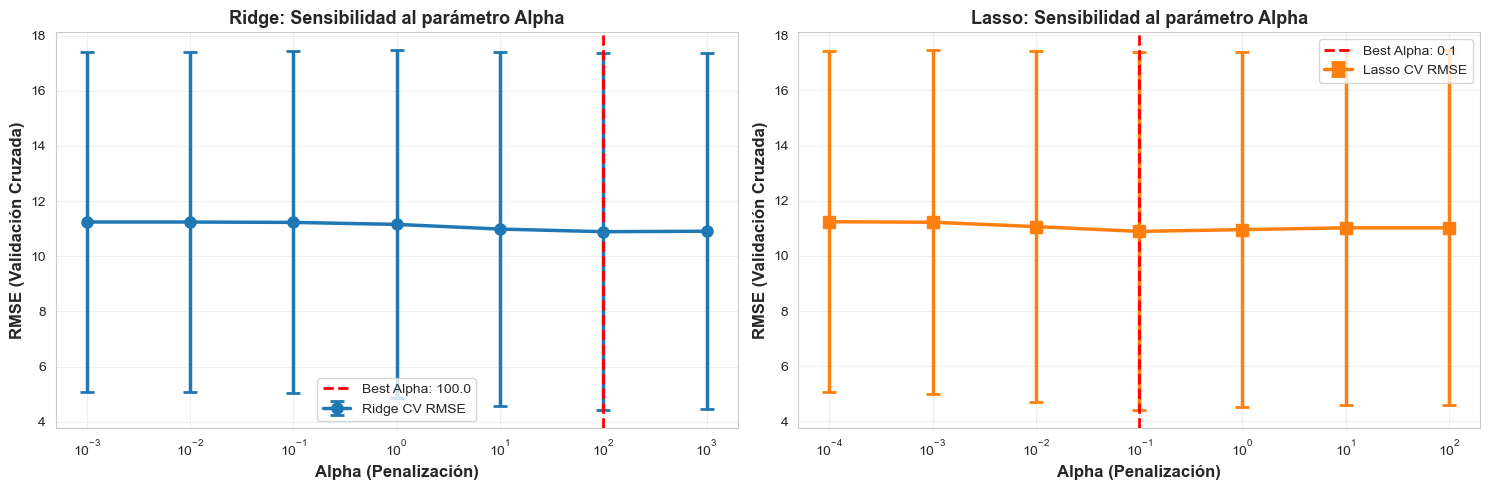



INTERPRETACIÓN DEL EFECTO ALPHA:

RIDGE (alpha = 100.0):
  • Alpha bajo → Coeficientes grandes, más sobreajuste
  • Alpha alto → Coeficientes pequeños, posible subajuste
  • Punto óptimo: Balance donde CV RMSE es mínimo

LASSO (alpha = 0.1):
  • Alpha bajo → Casi todas las variables seleccionadas
  • Alpha alto → Más variables llevadas a cero, modelo más simple
  • Punto óptimo: Minimiza CV RMSE mientras realiza selección

RECOMENDACIÓN:
  Los valores óptimos encontrados minimizan el error en validación cruzada,
  balanceando precisión con generalización y complejidad del modelo.



In [49]:

# 3.7 ANÁLISIS: Influencia del parámetro Alpha

print("\n" + "-"*100)
print("3.7 ANÁLISIS: INFLUENCIA DEL PARÁMETRO ALPHA (PENALIZACIÓN)")
print("-"*100)

# Extraer resultados de GridSearchCV para ambos modelos
cv_results_ridge = pd.DataFrame(grid_ridge.cv_results_)
cv_results_lasso = pd.DataFrame(grid_lasso.cv_results_)

print("\nRIDGE - Efecto del Alpha:")
print(cv_results_ridge[['param_modelo__alpha', 'mean_test_score', 'std_test_score']].round(6))

print("\n\nLASSO - Efecto del Alpha:")
print(cv_results_lasso[['param_modelo__alpha', 'mean_test_score', 'std_test_score']].round(6))

# Crear gráfico de sensibilidad a alpha
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ridge: Alpha vs RMSE
ax1 = axes[0]
alpha_ridge = cv_results_ridge['param_modelo__alpha'].values
rmse_ridge_mean = np.sqrt(-cv_results_ridge['mean_test_score'].values)
rmse_ridge_std = np.sqrt(cv_results_ridge['std_test_score'].values)

ax1.errorbar(alpha_ridge, rmse_ridge_mean, yerr=rmse_ridge_std, 
             marker='o', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             color='#1f77b4', label='Ridge CV RMSE')
ax1.axvline(x=best_alpha_ridge, color='red', linestyle='--', linewidth=2, label=f'Best Alpha: {best_alpha_ridge}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (Penalización)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (Validación Cruzada)', fontsize=12, fontweight='bold')
ax1.set_title('Ridge: Sensibilidad al parámetro Alpha', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Lasso: Alpha vs RMSE
ax2 = axes[1]
alpha_lasso = cv_results_lasso['param_modelo__alpha'].values
rmse_lasso_mean = np.sqrt(-cv_results_lasso['mean_test_score'].values)
rmse_lasso_std = np.sqrt(cv_results_lasso['std_test_score'].values)

ax2.errorbar(alpha_lasso, rmse_lasso_mean, yerr=rmse_lasso_std, 
             marker='s', linewidth=2.5, markersize=8, capsize=5, capthick=2,
             color='#ff7f0e', label='Lasso CV RMSE')
ax2.axvline(x=best_alpha_lasso, color='red', linestyle='--', linewidth=2, label=f'Best Alpha: {best_alpha_lasso}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (Penalización)', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (Validación Cruzada)', fontsize=12, fontweight='bold')
ax2.set_title('Lasso: Sensibilidad al parámetro Alpha', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/03b_alpha_sensitivity.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: ./outputs/03b_alpha_sensitivity.png")
plt.show()

print("\n" + "="*100)
print("\nINTERPRETACIÓN DEL EFECTO ALPHA:")
print("="*100)

print(f"""
RIDGE (alpha = {best_alpha_ridge}):
  • Alpha bajo → Coeficientes grandes, más sobreajuste
  • Alpha alto → Coeficientes pequeños, posible subajuste
  • Punto óptimo: Balance donde CV RMSE es mínimo

LASSO (alpha = {best_alpha_lasso}):
  • Alpha bajo → Casi todas las variables seleccionadas
  • Alpha alto → Más variables llevadas a cero, modelo más simple
  • Punto óptimo: Minimiza CV RMSE mientras realiza selección

RECOMENDACIÓN:
  Los valores óptimos encontrados minimizan el error en validación cruzada,
  balanceando precisión con generalización y complejidad del modelo.
""")
